# 제주도 퇴근 시간 버스 승차 인원 예측
- ## data 415423 rows × 21 columns

- ## 배경


    - 제주도내 주민등록인구 2019년 11월 기준 69만명, 외국인과 관광객까지 고려하면 전체 상주인구는 90만명을 넘을 것으로 추정. 
    - 제주도민과 외국인의 증가로 교통체증이 심각한 문제로 떠오르고 있습니다. 
    - * 2017년 한국은행 제주본부에 따르면 제주도 일부 지역은 교통체증이 서울보다 심각.
    
- ## 목적

    - 제주도내 버스의 효율적인 자원 분배를 위해 특정 정류장별, 노선별 18시~20시(퇴근시간)의 버스 승차 인원을 예측
    


In [241]:
# 추가되는 패키지는 여기에서 import 해주세요
import warnings
warnings.filterwarnings('ignore')
import missingno
import pandas as pd
import numpy as np
import datetime
import statsmodels.api as sm
import folium
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from sklearn.base import BaseEstimator, RegressorMixin
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from itertools import count
import geopy.distance
pd.options.mode.chained_assignment = None 

pd.set_option('display.max_columns', 500)

# matplotlib 설정
mpl.use('Agg')
mpl.rcParams['axes.unicode_minus'] = False
# seaborn 설정
sns.set()
sns.set_style("whitegrid")
sns.set_color_codes()

from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)



In [242]:
# 데이터 load
train = pd.read_csv('train.csv',date_parser='date')
train.tail()
# 분석을 위해 컬럼명 수정
train.rename(columns={'6~7_ride': 'ride6', '7~8_ride': 'ride7', '8~9_ride': 'ride8',\
                      '9~10_ride': 'ride9', '10~11_ride': 'ride10', '11~12_ride': 'ride11', 
                      '6~7_takeoff': 'off6', '7~8_takeoff': 'off7', '8~9_takeoff': 'off8', \
                      '9~10_takeoff': 'off9', '10~11_takeoff': 'off10', '11~12_takeoff': 'off11',\
                      '18~20_ride': 'ride18'},inplace=True)
train.tail()

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,ride6,ride7,ride8,ride9,ride10,ride11,off6,off7,off8,off9,off10,off11,ride18
415418,415418,2019-09-30,32820000,시내,1129,한림환승정류장(한림리),33.41437,126.26336,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
415419,415419,2019-09-30,32820000,시내,1564,제주시외버스터미널,33.49946,126.51479,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
415420,415420,2019-09-30,32820000,시내,2322,해병부대,33.23100,126.26273,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
415421,415421,2019-09-30,32820000,시내,3291,애월환승정류장(애월리),33.46483,126.31870,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
415422,415422,2019-09-30,32820000,시내,6115100,서귀포시외버스터미널,33.24873,126.50799,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0


    
### train columns

#### 날짜 / 노선 / 정류장별로 row를 구성
- `id` : 해당 데이터에서의 고유한 id
- `data` : 날짜
- `bus_route_id` : 노선 ID
- `in_out` : 시내버스, 시외버스 구분
- `station_code` : 해당 승하차 정류소의 id
- `station_name` : 해당 승하차 정류소의 이름
- `latitude` : 해당 버스정류장의 위도
- `longitude` : 해당 버스정류장의 경도
- `rideX` : X시부터 1시간 동안 승차한 인원 수 (오전 6시~ 오전 12시까지 측정) *`X`:6~11
- `offX` : X시부터 1시간 동안 하차한 인원 수 (오전 6시~ 오전 12시까지 측정) *`X`:6~11
- `ride18` : 18시부터 20시까지 승차한 인원 수

In [243]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 415423 entries, 0 to 415422
Data columns (total 21 columns):
id              415423 non-null int64
date            415423 non-null object
bus_route_id    415423 non-null int64
in_out          415423 non-null object
station_code    415423 non-null int64
station_name    415423 non-null object
latitude        415423 non-null float64
longitude       415423 non-null float64
ride6           415423 non-null float64
ride7           415423 non-null float64
ride8           415423 non-null float64
ride9           415423 non-null float64
ride10          415423 non-null float64
ride11          415423 non-null float64
off6            415423 non-null float64
off7            415423 non-null float64
off8            415423 non-null float64
off9            415423 non-null float64
off10           415423 non-null float64
off11           415423 non-null float64
ride18          415423 non-null float64
dtypes: float64(15), int64(3), object(3)
memory usage: 66.

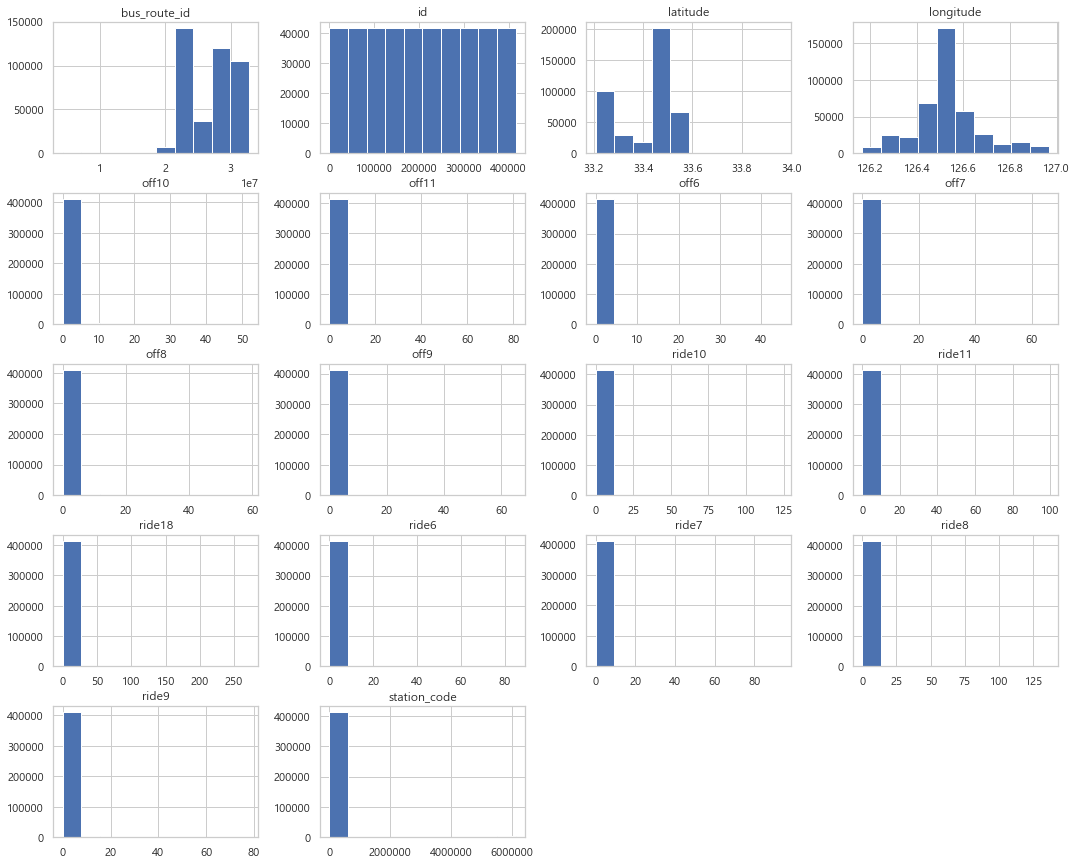

In [244]:
train.hist(figsize = (18,15))
plt.show()

In [245]:
train.describe()

,id,bus_route_id,station_code,latitude,longitude,ride6,ride7,ride8,ride9,ride10,ride11,off6,off7,off8,off9,off10,off11,ride18
count,415423.000000,4.154230e+05,4.154230e+05,415423.000000,415423.000000,415423.000000,415423.000000,415423.000000,415423.000000,415423.000000,415423.000000,415423.000000,415423.000000,415423.000000,415423.000000,415423.000000,415423.000000,415423.000000
mean,207711.000000,2.691935e+07,4.209311e+04,33.420375,126.533574,0.305893,0.829699,0.815350,0.642475,0.599618,0.579393,0.112870,0.344870,0.516481,0.430922,0.408001,0.402874,1.242095
std,119922.434776,3.924652e+06,4.971504e+05,0.107996,0.140986,1.109766,2.255116,2.317561,1.959844,1.885941,1.942137,0.597714,1.279179,1.658850,1.485124,1.412839,1.446080,4.722287
min,0.000000,4.270000e+06,1.000000e+00,33.208350,126.165040,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,103855.500000,2.346000e+07,3.200000e+02,33.291080,126.475780,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,207711.000000,2.803000e+07,1.130000e+03,33.478850,126.529770,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,311566.500000,3.003000e+07,2.226000e+03,33.500020,126.575890,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,415422.000000,3.282000e+07,6.115101e+06,33.963640,126.965670,85.000000,94.000000,136.000000,78.000000,124.000000,99.000000,45.000000,66.000000,59.000000,65.000000,52.000000,81.000000,272.000000


In [249]:
print('1: id의 갯수는 {}개 입니다.'.format(len(train.id.unique())))
print('2: station_code 값의 갯수는 {}개 입니다.'.format(len(train.station_code.unique())))
print('3: bus_route_id 값의 갯수는 {}개 입니다.'.format(len(train.bus_route_id.unique())))

1: id의 갯수는 415423개 입니다.
2: station_code 값의 갯수는 3563개 입니다.
3: bus_route_id 값의 갯수는 613개 입니다.


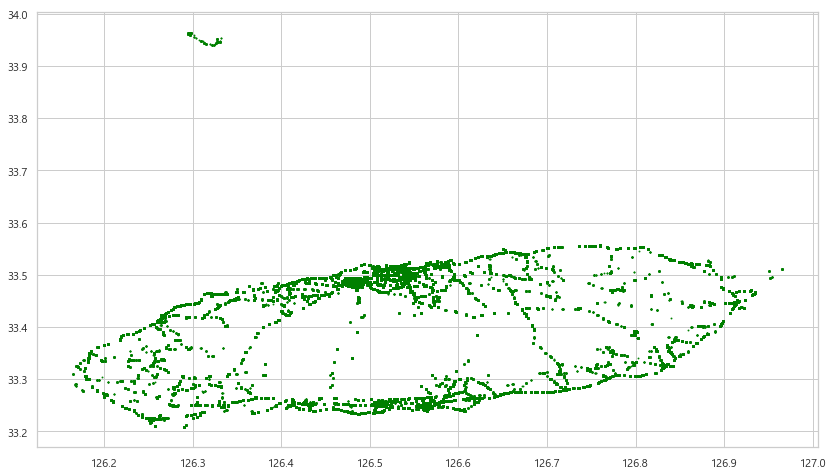

In [255]:
# 위도 경도 확인
plt.figure(figsize = (14,8))
plt.scatter('longitude','latitude',data=train,  s = 0.8, edgecolor = 'green')
plt.show()

In [256]:
#9월 15일: 연휴 끝난 일요일 / 추석 연휴를 마치고 돌아온 사람들이 몰렸을 가능성
train.query('ride18 == 272')

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,ride6,ride7,ride8,ride9,ride10,ride11,off6,off7,off8,off9,off10,off11,ride18
190528,190528,2019-09-15,23620000,시내,638,제주국제공항(구제주방면),33.50661,126.49345,3.0,31.0,32.0,49.0,36.0,41.0,6.0,14.0,20.0,11.0,8.0,8.0,272.0


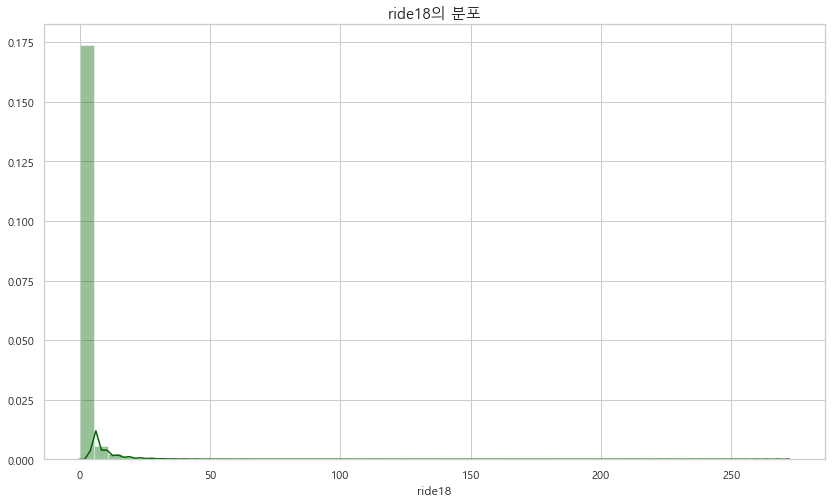

In [257]:
#max(ride18): 제주국제공항 272명
plt.figure(figsize = (14,8))
sns.distplot(train.ride18, color ='darkgreen')
plt.title('ride18의 분포', fontsize = 15)
plt.show()

In [258]:
terribles = train.query('ride18 >= 50')
list(terribles.query('ride18>=80').station_name.unique())

['제주고등학교/중흥S클래스',
 '은남동',
 '제주국제공항(신제주방면)',
 '제주국제공항(구제주방면)',
 '제주대학교',
 '제주시청(광양방면)',
 '제주한라대학교',
 '제주관광대학',
 '제주한라대학교(종점)',
 '제주시청(아라방면)',
 '회천입구',
 '중앙로터리(동)',
 '산천단한국폴리텍대학',
 '중앙로(국민은행)',
 '제원아파트',
 '제주국제공항(600번)',
 '제주국제공항(대정,화순,일주서로)',
 '큰동네',
 '시외버스출발지(가상정류소)',
 '수산리사무소앞',
 '제주대학교병원',
 '한라수목원',
 '제주버스터미널']

### 9월 한달 간 50명 18시~ 20시 동안 한 노선에 50명 이상이 탑승한 정류장

In [259]:
map_osm = folium.Map(location=[33.48944, 126.48508], zoom_start= 11)
for i in terribles.index:
    folium.CircleMarker([terribles.loc[i,'latitude'], terribles.loc[i,'longitude']], radius= terribles.loc[i,'ride18']/20 ,color='red',fill_color='#red', popup= terribles.loc[i,'bus_route_id']).add_to(map_osm)
map_osm

In [260]:
# 시작 날짜와, 끝 날짜 확인
print(train['date'].min())
print(train['date'].max())
# date 타입 변경
train['date'] = train['date'].astype('datetime64')
# 9월 1일 ~ 9월 30일 데이터이니까, day만 따로 가져옴
train['date_day'] = train['date'].dt.day
# 월(0) ~ 일(6) 데이터로 변환
train['date_dayofweek'] = train['date'].dt.dayofweek
train['date_dayofname']= train['date'].dt.weekday_name
train[['date','date_dayofweek','date_day','date_dayofname']]

# 추석 추가 컬럼명 : 'thanksgiving_Day'
train['thanksgiving_Day'] = 0
train.loc[train['date'] == '2019-09-14', 'thanksgiving_Day'] = 1
train.loc[train['date'] == '2019-09-13', 'thanksgiving_Day'] = 1
train.loc[train['date'] == '2019-09-12', 'thanksgiving_Day'] = 1
print(train['thanksgiving_Day'].sum())
# 제대로 바뀌었는지 확인
train[train['date'] == '2019-09-14'].count()[0] + \
train[train['date'] == '2019-09-12'].count()[0] + \
train[train['date'] == '2019-09-13'].count()[0]

2019-09-01
2019-09-30
30719


30719

### 어떤 변수들을 고려해야 할까?
- 2019년 9월 1일(일요일) ~ 2019년 9월 30일(월요일)
- 2019년 9월 12일~14일 추석 공휴일, 15일은 일요일 : 공휴일과 주말을 고려하자
- 2918년 9월 6일 태풍 : 날씨도 고려하자

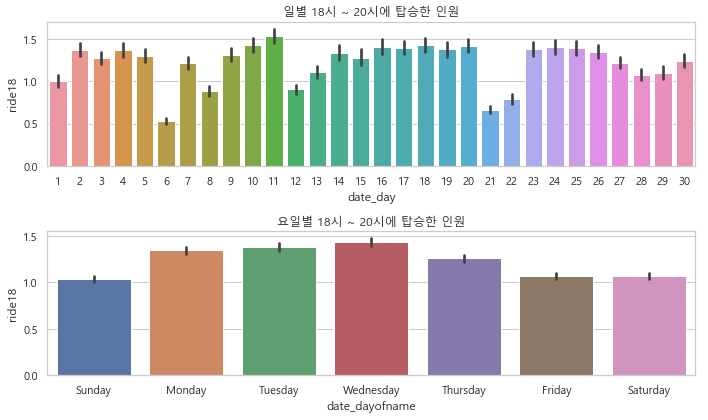

In [261]:
# 일별, 요일별 탑승한 인원 그래프
plt.figure(figsize=(10, 6))
plt.subplot(211)
plt.title('일별 18시 ~ 20시에 탑승한 인원')
sns.barplot(x='date_day', y='ride18', data=train)

plt.subplot(212)
plt.title('요일별 18시 ~ 20시에 탑승한 인원')
sns.barplot(x='date_dayofname', y='ride18', data=train)
plt.tight_layout()
plt.show()

### 상관관계
- 오전에 많이 타고 많이 내리는 곳 = 18~20시에 많이 타는 곳

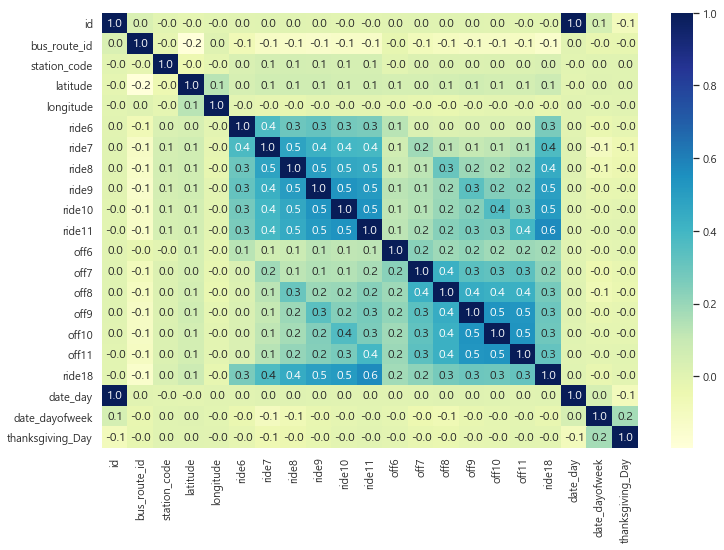

In [262]:
plt.figure(figsize=(12, 8))
sns.heatmap(train.corr(), annot=True, cmap= 'YlGnBu', fmt='.1f')
plt.show()

### 시행착오
- 버스 정류장 3563개, 버스 노선 613개를 모두 카테고리화 할 수 없다 (41만행)
- 둘을 제외하고 분석을 실행하니 R^2가 너무 낮게 나왔다. (0.44) 이를 높이기 위해
    - 어떻게든 버스 정류장의 위치 정보를 나타내려 는 시도
        - 시도1: 제주시, 서귀포시에서의 거리를 구한다
        - 시도2: 주소를 기반으로 범주화한다
    - 외부 데이터를 결합해 추가 feature (날씨 데이터) 생성

In [15]:
cols = list(train.columns)
cate = ['in_out','date_dayofweek','station_code','thanksgiving_Day']
unnecessary = ['id','date','bus_route_id','station_name','latitude','longitude','date_day','date_dayofname','ride18']
[cols.remove(cat) for cat in cate]
[cols.remove(un) for un in unnecessary]
var = cols
var_scale = ["scale({})".format(name) for name in var]
var_scale

['scale(ride6)',
 'scale(ride7)',
 'scale(ride8)',
 'scale(ride9)',
 'scale(ride10)',
 'scale(ride11)',
 'scale(off6)',
 'scale(off7)',
 'scale(off8)',
 'scale(off9)',
 'scale(off10)',
 'scale(off11)']

In [16]:
model = sm.OLS.from_formula(
    'ride18 ~ C(station_code) + C(date_dayofweek) + '+'+'.join(var_scale), data=train)
result = model.fit()
print(result.summary())

MemoryError: 

In [17]:
model = sm.OLS.from_formula(
    'ride18 ~ C(thanksgiving_Day) + C(date_dayofweek) + '+'+'.join(var_scale), data=train)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                 ride18   R-squared:                       0.443
Model:                            OLS   Adj. R-squared:                  0.443
Method:                 Least Squares   F-statistic:                 1.739e+04
Date:                Sat, 04 Apr 2020   Prob (F-statistic):               0.00
Time:                        07:16:46   Log-Likelihood:            -1.1128e+06
No. Observations:              415423   AIC:                         2.226e+06
Df Residuals:                  415403   BIC:                         2.226e+06
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

### 도심에서의 거리 구하기(KM)

In [263]:
coords_jejusi = (33.500770, 126.522761) #제주시의 위도 경도
coords_seoquipo = (33.259429, 126.558217) #서귀포시의 위도 경도
train['dis_jejusi'] = [geopy.distance.vincenty((train['latitude'].iloc[i],train['longitude'].iloc[i]), coords_jejusi).km for i in range(len(train))]
train['dis_seoquipo'] = [geopy.distance.vincenty((train['latitude'].iloc[i],train['longitude'].iloc[i]), coords_seoquipo).km for i in range(len(train))]

In [264]:
train.head()

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,ride6,ride7,ride8,ride9,ride10,ride11,off6,off7,off8,off9,off10,off11,ride18,date_day,date_dayofweek,date_dayofname,thanksgiving_Day,dis_jejusi,dis_seoquipo
0,0,2019-09-01,4270000,시외,344,제주썬호텔,33.48990,126.49373,0.0,1.0,2.0,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,6,Sunday,0,2.954920,26.256744
1,1,2019-09-01,4270000,시외,357,한라병원,33.48944,126.48508,1.0,4.0,4.0,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,1,6,Sunday,0,3.720275,26.403025
2,2,2019-09-01,4270000,시외,432,정존마을,33.48181,126.47352,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1,6,Sunday,0,5.036124,25.893305
3,3,2019-09-01,4270000,시내,1579,제주국제공항(600번),33.50577,126.49252,0.0,17.0,6.0,26.0,14.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0,1,6,Sunday,0,2.864166,27.997494
4,4,2019-09-01,4270000,시내,1646,중문관광단지입구,33.25579,126.41260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,6,Sunday,0,29.040353,13.574693


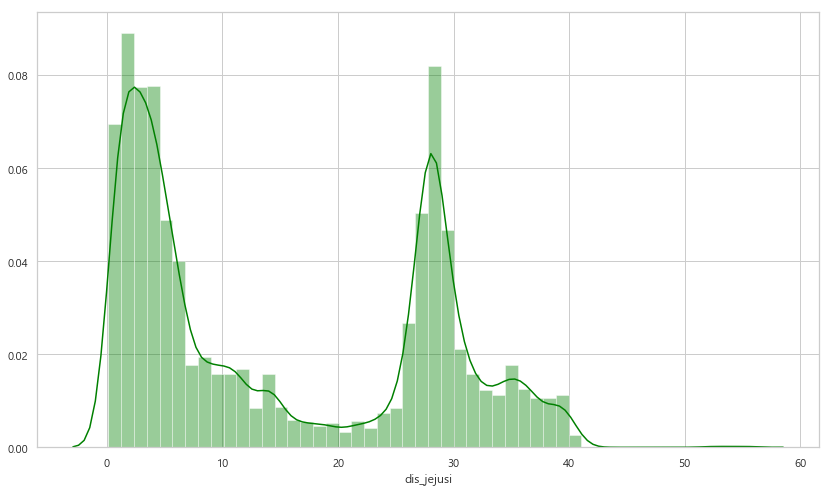

In [265]:
plt.figure(figsize = (14,8))
sns.distplot(train.dis_jejusi, color = 'green')
plt.show()

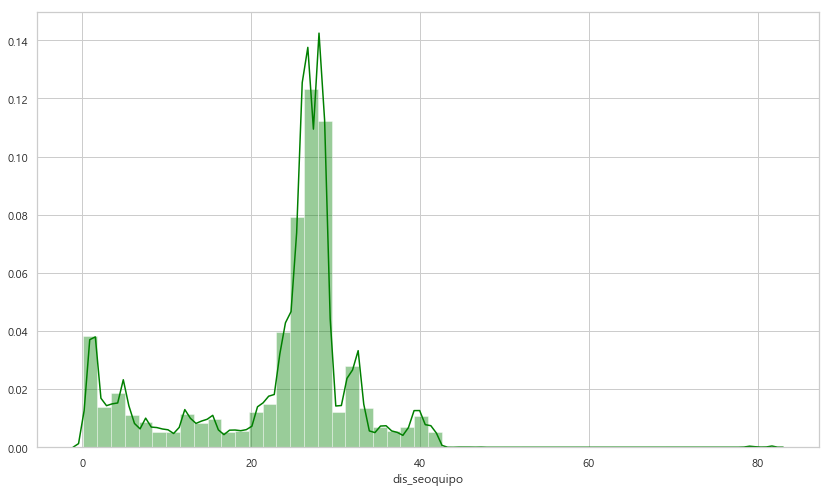

In [266]:
plt.figure(figsize = (14,8))
sns.distplot(train.dis_seoquipo, color = 'green')
plt.show()

### 도심에서의 거리와 퇴근시간 승차
- 실수형으로 도심에서의 거리를 나타냈지만, 거리와 ride18의 관계가 선형 관계가 아니었다.

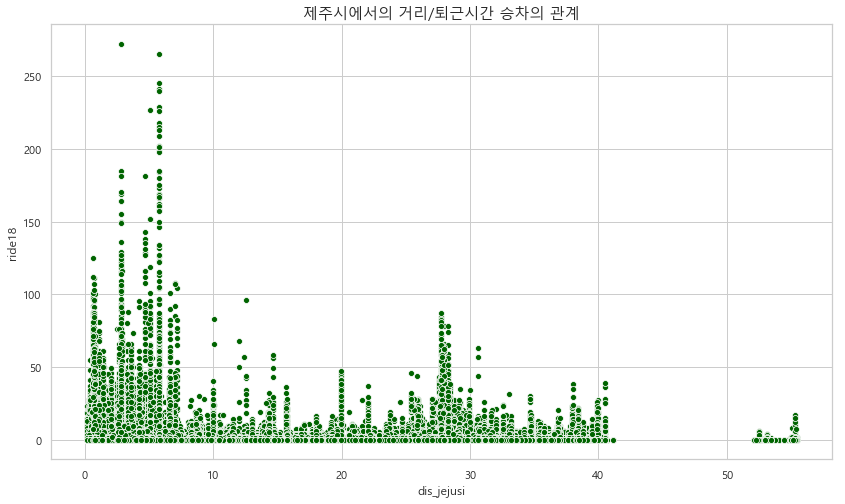

In [267]:
plt.figure(figsize = (14,8))
sns.scatterplot(train.dis_jejusi, train.ride18, color = 'darkgreen')
plt.title('제주시에서의 거리/퇴근시간 승차의 관계', fontsize = 15)
plt.show()

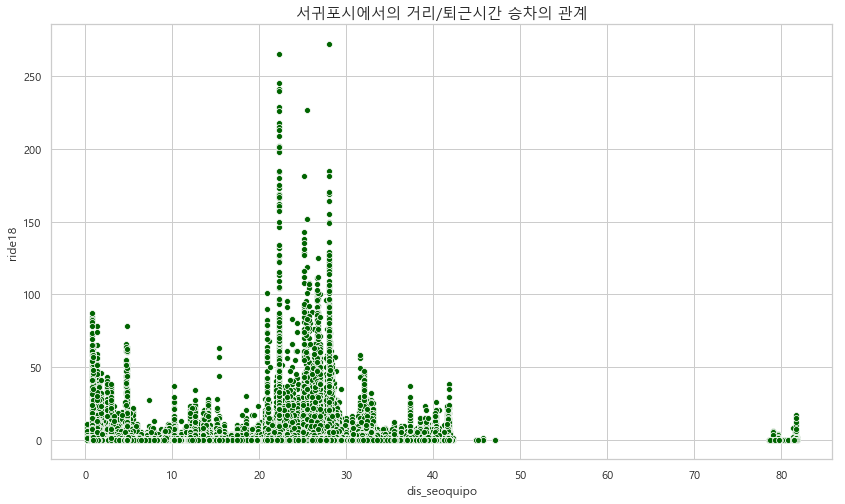

In [268]:
plt.figure(figsize = (14,8))
sns.scatterplot(train.dis_seoquipo, train.ride18, color = 'darkgreen')
plt.title('서귀포시에서의 거리/퇴근시간 승차의 관계', fontsize = 15)
plt.show()

### 주소 기반 정류장 범주화

In [269]:
jeju_addr = pd.read_csv('jeju_addr.csv')
jeju_addr.tail()

,station_code,city,addr,road_addr
3559,6115052.0,제주시,우도면,우도해안길
3560,6115059.0,제주시,우도면,우목길
3561,6115100.0,서귀포시,법환동,일주동로
3562,6115101.0,서귀포시,법환동,일주동로
3563,NaN,NaN,NaN,NaN


In [270]:
train = train.merge(jeju_addr, left_on ='station_code' , right_on = 'station_code')
train.tail()

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,ride6,ride7,ride8,ride9,ride10,ride11,off6,off7,off8,off9,off10,off11,ride18,date_day,date_dayofweek,date_dayofname,thanksgiving_Day,dis_jejusi,dis_seoquipo,city,addr,road_addr
415418,374291,2019-09-28,20010000,시외,6115044,대서리,33.96252,126.29429,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28,5,Saturday,0,55.420244,81.739546,제주시,추자면,추자로
415419,393524,2019-09-29,27880000,시내,1368,저지리알못,33.33595,126.26332,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,29,6,Sunday,0,30.273053,28.747464,제주시,한경면,용금로
415420,397921,2019-09-29,31580000,시내,3576,어썸브리즈,33.25899,126.27554,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,29,6,Sunday,0,35.331147,26.339595,서귀포시,대정읍,보성구억로
415421,400433,2019-09-30,22210000,시내,1585,셰프라인월드,33.43489,126.73242,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30,0,Monday,0,20.813985,25.331042,제주시,구좌읍,비자림로
415422,406662,2019-09-30,27180000,시내,3552,행원교차로,33.54574,126.80370,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,30,0,Monday,0,26.570918,39.113855,제주시,구좌읍,일주동로


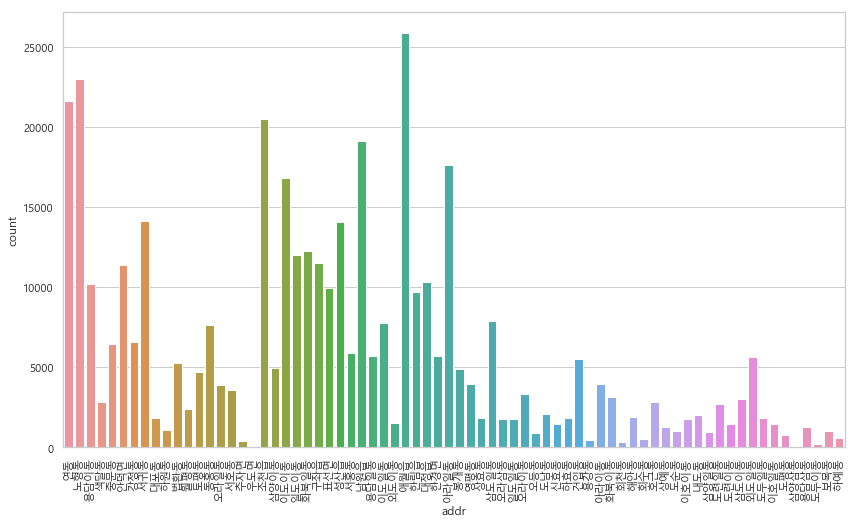

In [271]:
plt.figure(figsize = (14,8))
sns.countplot(train.addr)
plt.xticks(rotation = 90)
plt.show()

In [272]:
cols = list(train.columns)
cols

['id',
 'date',
 'bus_route_id',
 'in_out',
 'station_code',
 'station_name',
 'latitude',
 'longitude',
 'ride6',
 'ride7',
 'ride8',
 'ride9',
 'ride10',
 'ride11',
 'off6',
 'off7',
 'off8',
 'off9',
 'off10',
 'off11',
 'ride18',
 'date_day',
 'date_dayofweek',
 'date_dayofname',
 'thanksgiving_Day',
 'dis_jejusi',
 'dis_seoquipo',
 'city',
 'addr',
 'road_addr']

In [273]:
cols = list(train.columns)
cate = ['in_out','date_dayofweek','station_code','thanksgiving_Day','city','addr','road_addr']
unnecessary = ['id','date','bus_route_id','station_name','latitude','longitude','date_day','date_dayofname','ride18']
[cols.remove(cat) for cat in cate]
[cols.remove(un) for un in unnecessary]
var = cols
var_scale = ["scale({})".format(name) for name in var]
var_scale

['scale(ride6)',
 'scale(ride7)',
 'scale(ride8)',
 'scale(ride9)',
 'scale(ride10)',
 'scale(ride11)',
 'scale(off6)',
 'scale(off7)',
 'scale(off8)',
 'scale(off9)',
 'scale(off10)',
 'scale(off11)',
 'scale(dis_jejusi)',
 'scale(dis_seoquipo)']

In [275]:
model = sm.OLS.from_formula(
    'ride18 ~ C(thanksgiving_Day) + C(date_dayofweek) + C(addr) +'+'+'.join(var_scale), data=train)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                 ride18   R-squared:                       0.455
Model:                            OLS   Adj. R-squared:                  0.455
Method:                 Least Squares   F-statistic:                     3776.
Date:                Sat, 04 Apr 2020   Prob (F-statistic):               0.00
Time:                        10:32:15   Log-Likelihood:            -1.1081e+06
No. Observations:              415423   AIC:                         2.216e+06
Df Residuals:                  415330   BIC:                         2.217e+06
Df Model:                          92                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

### 하나의 모델을 포기하자
- 41만행 x 3563개+의 카테고리 변수를 한 모델로 돌리기엔 메모리가 부족
- 작은 모델들을 여러개 만들면 `정류장 코드`를 사용할 수 있지 않을까?
- `정류장 코드`를 대신하기 위해 만든 `제주시에서의거리(km)`, `서귀포시에서의거리(km)`, `주소카테고리` 를 사용하지 않아도 된다

In [276]:
print('정류장 코드의 개수는 {}개, 노선 번호는 {}개'.format(len(train.station_code.unique()),len(train.bus_route_id.unique())))

정류장 코드의 개수는 3563개, 노선 번호는 613개


In [277]:
def ols(data, var, cate):

    columns = data.columns
    df_train = pd.DataFrame(columns=columns)
    df_train['yhat'] = 0

    # 모델 학습
    for i in data['station_code'].unique():
        sample = data[data['station_code'] == i]

        model = sm.OLS.from_formula(
            'ride18  ~ ' + '+'.join(var) + '+'.join('+') + '+'.join(cate_c), data=sample)
        result = model.fit()
        sample['yhat'] = result.predict()
        df1 = pd.DataFrame(sample, columns=df_train.columns)
        df_train = pd.concat([df_train, df1])

    df_train.loc[df_train['yhat'] < 0, 'yhat'] = 0
    df_train['yhat'] = round(df_train['yhat'])
    df_train['residual'] = df_train['ride18'] - df_train['yhat']
    df_train['explained'] = df_train['yhat'] - df_train['yhat'].mean()
    df_train['total'] = df_train['ride18'] - df_train['ride18'].mean()
    return df_train

In [278]:
np.random.seed(10)
train_test = train.copy()
test_frame = pd.DataFrame(columns=train_test.columns)
for i in np.random.choice(train_test['station_code'].unique(), 100, replace=False):
    df1 = train_test[train_test['station_code'] == i]
    test_frame = pd.concat([test_frame, df1])

In [279]:
test_frame.shape

(11514, 30)

In [280]:
import time
var = ['ride6', 'ride7', 'ride8', 'ride9', 'ride10', 'ride11',
       'off6', 'off7', 'off8', 'off9', 'off10', 'off11']
cate = ['in_out', 'thanksgiving_Day', 'date_day', 'date_dayofweek','bus_route_id']
var_scale = ["scale({})".format(name) for name in var]
cate_c = ["C({})".format(name) for name in cate]

# 함수 사용
start= time.time()
df = ols(test_frame, var, cate)
end = time.time()
print(end-start)

5.785094499588013


In [281]:
ess = (df['explained'] ** 2).sum()
rss = (df['residual'] ** 2).sum()
tss = (df['total'] ** 2).sum()
print('ESS는 {} 입니다.'.format(ess))
print('RSS는 {} 입니다.'.format(rss))
print('TSS는 {} 입니다.'.format(tss))
print('결정계수는 {} 입니다.'.format(1-rss/tss))

ESS는 107218.15363904813 입니다.
RSS는 32864.0 입니다.
TSS는 141625.43694632623 입니다.
결정계수는 0.7679512896228173 입니다.


In [282]:
df.head()

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,ride6,ride7,ride8,ride9,ride10,ride11,off6,off7,off8,off9,off10,off11,ride18,date_day,date_dayofweek,date_dayofname,thanksgiving_Day,dis_jejusi,dis_seoquipo,city,addr,road_addr,yhat,residual,explained,total
385870,9302,2019-09-01,30730000,시내,2846,굿밭거리,33.25746,126.52505,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1,6,Sunday,0,26.98665,3.0982,서귀포시,호근동,호근서호로,1.0,0.0,-0.157287,-0.120636
385871,10198,2019-09-01,31660000,시내,2846,굿밭거리,33.25746,126.52505,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,6,Sunday,0,26.98665,3.0982,서귀포시,호근동,호근서호로,0.0,0.0,-1.157287,-1.120636
385872,23495,2019-09-02,30740000,시내,2846,굿밭거리,33.25746,126.52505,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0,Monday,0,26.98665,3.0982,서귀포시,호근동,호근서호로,0.0,0.0,-1.157287,-1.120636
385873,24613,2019-09-02,31640000,시내,2846,굿밭거리,33.25746,126.52505,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0,Monday,0,26.98665,3.0982,서귀포시,호근동,호근서호로,0.0,0.0,-1.157287,-1.120636
385874,24738,2019-09-02,31700000,시내,2846,굿밭거리,33.25746,126.52505,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0,Monday,0,26.98665,3.0982,서귀포시,호근동,호근서호로,0.0,0.0,-1.157287,-1.120636


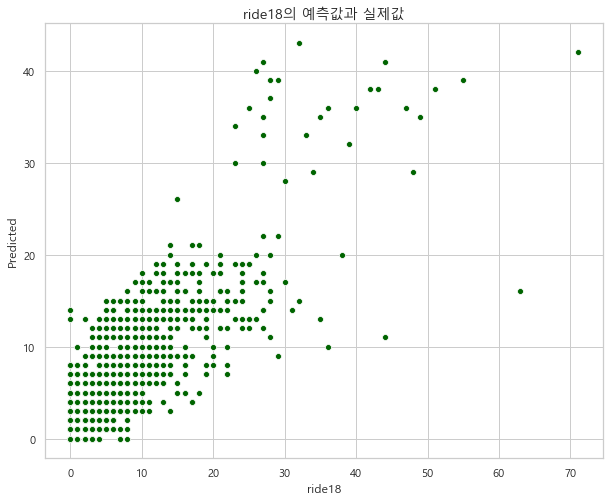

In [283]:
plt.figure(figsize = (10,8))
plt.title('ride18의 예측값과 실제값', fontsize = 14)
sns.scatterplot(df.ride18, df.yhat, color = 'darkgreen')
plt.ylabel('Predicted')
plt.show()

### 모델을 세분화하며 새로 발생한 문제
- test, train 셋을 분리할 때, 카테고리 변수들이 train 에 포함되지 않는 문제 발생
- 비정기 운행 (4째 주에는 있지만, 1-3째 주에는 기록이 없는 정류장들)

In [136]:
df = train['station_code'].value_counts().reset_index()
df.columns = ['station_code','counts']
outliers = df.query('counts < 30').merge(train[['station_code','bus_route_id','station_name','latitude','longitude']]).reset_index(drop = True)
outliers.tail()

,station_code,counts,bus_route_id,station_name,latitude,longitude
15877,4122,1,27700000,붉으내,33.31893,126.17250
15878,4056,1,22200000,수산체육공원입구,33.45033,126.85083
15879,1558,1,32660000,유수암리입구,33.44339,126.39103
15880,3034,1,27330000,도린동산,33.35824,126.76816
15881,3122,1,28520000,하도리개긋물,33.50150,126.88263


In [174]:
import pandas as pd
# 한달에 30회 미만 운행하는 정류장구하기
outlier = pd.DataFrame(train['station_code'].value_counts().sort_values(ascending = True)).reset_index()
outlier.columns = ['station_code', 'times']
outlier = outlier[outlier['times'] <= 29]
outlier = outlier.merge(train[['station_code','station_name','latitude','longitude']])
outlier.head()

,station_code,times,station_name,latitude,longitude
0,3122,1,하도리개긋물,33.50150,126.88263
1,3247,1,제주세계자연유산센터입구,33.45543,126.71040
2,2684,1,신례리,33.28472,126.63338
3,6115016,1,장작평사,33.94036,126.32339
4,1324,1,선린지,33.49331,126.71556


In [176]:
len(outlier.station_name.unique())

783

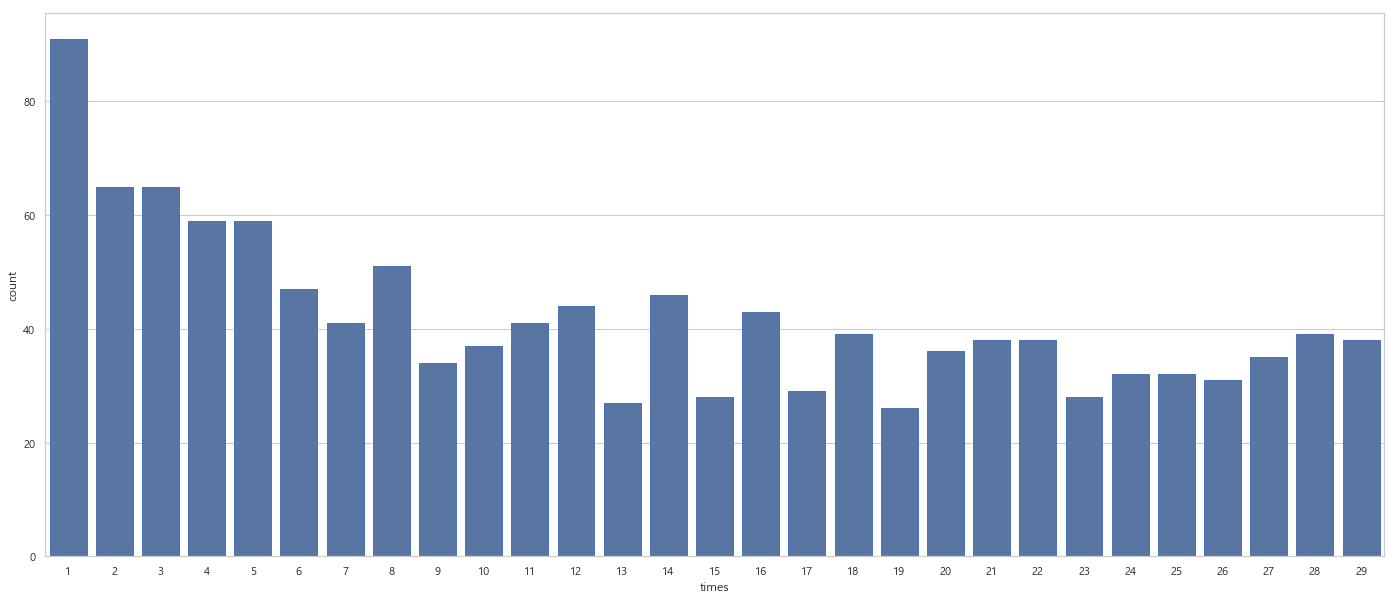

In [141]:
# 한달에 30번 미만 운행하는 정류장의 count플롯
plt.figure(figsize=(24,10))
sns.countplot(x ='times', data = outlier,edgecolor='b', color='b')
plt.show()

In [142]:
# 한달에 30번 미만 운행하는 정류소는 아웃라이어로 삭제
train_test = train.copy()
for i in outlier['station_code'] :
    train_test = train_test[train_test['station_code'] != i]
train_test

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,ride6,ride7,ride8,ride9,ride10,ride11,off6,off7,off8,off9,off10,off11,ride18,date_day,date_dayofweek,date_dayofname,thanksgiving_Day,dis_jejusi,dis_seoquipo,city,addr,road_addr
0,0,2019-09-01,4270000,시외,344,제주썬호텔,33.48990,126.49373,0.0,1.0,2.0,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,6,Sunday,0,2.954920,26.256744,제주시,연동,삼무로
1,11538,2019-09-02,4270000,시외,344,제주썬호텔,33.48990,126.49373,1.0,8.0,3.0,3.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2,0,Monday,0,2.954920,26.256744,제주시,연동,삼무로
2,26498,2019-09-03,4270000,시외,344,제주썬호텔,33.48990,126.49373,2.0,4.0,2.0,7.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,1,Tuesday,0,2.954920,26.256744,제주시,연동,삼무로
3,41983,2019-09-04,4270000,시외,344,제주썬호텔,33.48990,126.49373,3.0,3.0,1.0,2.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,2,Wednesday,0,2.954920,26.256744,제주시,연동,삼무로
4,56722,2019-09-05,4270000,시외,344,제주썬호텔,33.48990,126.49373,2.0,4.0,8.0,0.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,5,3,Thursday,0,2.954920,26.256744,제주시,연동,삼무로
5,72428,2019-09-06,4270000,시외,344,제주썬호텔,33.48990,126.49373,0.0,3.0,3.0,2.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,4,Friday,0,2.954920,26.256744,제주시,연동,삼무로
6,87780,2019-09-07,4270000,시외,344,제주썬호텔,33.48990,126.49373,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,7,5,Saturday,0,2.954920,26.256744,제주시,연동,삼무로
7,97978,2019-09-08,4270000,시외,344,제주썬호텔,33.48990,126.49373,1.0,1.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8,6,Sunday,0,2.954920,26.256744,제주시,연동,삼무로
8,109560,2019-09-09,4270000,시외,344,제주썬호텔,33.48990,126.49373,4.0,3.0,3.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9,0,Monday,0,2.954920,26.256744,제주시,연동,삼무로
9,124857,2019-09-10,4270000,시외,344,제주썬호텔,33.48990,126.49373,1.0,2.0,1.0,1.0,3.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,10,1,Tuesday,0,2.954920,26.256744,제주시,연동,삼무로


In [137]:
len(outliers.bus_route_id.unique())

442

In [222]:
data = train.copy()

In [232]:
# 9월 1일 ~ 9월 21일 = train
# 9월 22일 ~ 9월 30일 = test
# 학습 및 검증은 train으로하고 test는 실제 모델에 사용해봄
df_train = train_test[data['date']  <= '2019-09-21']
df_test = train_test[data['date']  >= '2019-09-22']

In [233]:
# test와 train의 비율 및 정류소의 갯수 (둘다 동일하게 들어갔는지.)
print('train의 비율:', len(df_train) / len(train_test), 'test의 비율:', len(df_test) / len(train_test))

print('전체의 정류소 갯수:', len(train_test['station_code'].unique()))
print('train의 정류소 갯수:', len(df_train['station_code'].unique()))
print('test의 정류소 갯수:', len(df_test['station_code'].unique()))
print('train의 노선 갯수:', len(df_train['bus_route_id'].unique()))
print('test의 노선 갯수:', len(df_test['bus_route_id'].unique()))

train의 비율: 0.696178865247872 test의 비율: 0.3038211347521281
전체의 정류소 갯수: 2344
train의 정류소 갯수: 2344
test의 정류소 갯수: 2344
train의 노선 갯수: 601
test의 노선 갯수: 578


In [234]:
# 한달에 비정기적으로 운행하는 노선 확인(1)
y = list(set(df_train['bus_route_id'].unique()) - set(df_test['bus_route_id'].unique()))
print(len(y))

# 비정기적으로 운행하는 노선 삭제
df_train = df_train.copy()
for i in y :
    df_train = df_train[df_train['bus_route_id'] != i]


# 한달에 비정기적으로 운행하는 노선 확인(2)
y = list(set(df_test['bus_route_id'].unique()) - set(df_train['bus_route_id'].unique()))
print(len(y))

# 비정기적으로 운행하는 노선 삭제
df_test = df_test.copy()
for i in y :
    df_test = df_test[df_test['bus_route_id'] != i]
# df_test

31
8


In [236]:
# test와 train의 비율 및 정류소의 갯수 (둘다 동일하게 들어갔는지.)
print('train의 비율:', len(df_train) / len(train_test), 'test의 비율:', len(df_test) / len(train_test))

print('전체의 정류소 갯수:', len(train_test['station_code'].unique()))
print('train의 정류소 갯수:', len(df_train['station_code'].unique()))
print('test의 정류소 갯수:', len(df_test['station_code'].unique()))
print('train의 노선 갯수:', len(df_train['bus_route_id'].unique()))
print('test의 노선 갯수:', len(df_test['bus_route_id'].unique()))

train의 비율: 0.6952978542877952 test의 비율: 0.30367096242938774
전체의 정류소 갯수: 2344
train의 정류소 갯수: 2344
test의 정류소 갯수: 2344
train의 노선 갯수: 570
test의 노선 갯수: 570


In [187]:
# 테스트 데이터 프레임 나누기
# 간략화 하기 위해 데이터 프레임에서 정류장코드 몇개만 가져오기

def split(num, seed):
    test_frame = pd.DataFrame(columns=df_train.columns)
    np.random.seed(seed)

    for i in np.random.choice(df_train['station_code'].unique(), num, replace=False):
        df1 = df_train[df_train['station_code'] == i]
        test_frame = pd.concat([test_frame, df1])
    return test_frame

# 모델 돌리기
def ols_train_test(test_frame, seed, var, cate):
    np.random.seed(seed)
    columns = test_frame.columns
    df_tr = pd.DataFrame(columns=columns)
    df_te = pd.DataFrame(columns=columns)
    df_tr['yhat'] = 999
    df_te['yhat'] = 999

    # 데이터를 받아, 스테이션 코드 1개만 출력하여 
    for i in test_frame['station_code'].unique():
        # df1로 저장
        df1 = test_frame[test_frame['station_code'] == i]
        # df1을 id 갯수로 피벗테이블 변경
        table = df1.pivot_table(index=['bus_route_id'], values=['id'], aggfunc=len).reset_index()
        # 변경된 피벗테이블에서 id의  1(노선이 1개인것과 동일)한것을 table에 저장
        table = table[table['id'] == 1]
        
        # 데이터라는 빈데이터프레임을 만들고
        data = pd.DataFrame(columns=test_frame.columns)
        # id가 1인 테이블에서 
        
        for i in table['bus_route_id']:
            # 1인 데이터만 data 프레임에 저장
            data = data.append(df1[df1['bus_route_id'] == i],ignore_index = True)
        # df1과 data 프레임을 합침    
        
        df1 = pd.concat([df1,data]).reset_index(drop=True)

        # 정류소별로 테스트와 나누기
        # 빈 리스트 2개를 만들고
        ls_idx_1 = []
        ls_idx_2 = []
            # 앞에서 만든 df1의 버스 아이디를 가져와서
        for num in df1["bus_route_id"].unique():
            #df1의 버스 루트아이디의 인덱스를 idx변수에 담고
            idx = df1[df1["bus_route_id"] == num].index
            # idx1과 idx2로 2등분 해줌 (8:2 수준)
            idx_1 = np.random.choice(idx, int(len(idx) *0.7), replace=False)
            idx_2 = df1.loc[idx].drop(axis=1, index=idx_1).index
            # 리스트에 차곡차곡 다 저장
            ls_idx_1 += list(idx_1)
            ls_idx_2 += list(idx_2)
            # 리스트에 저장된 인덱스를 idx_1_df와 2df로 만듬
            idx_1_df = df1.loc[ls_idx_1]
            idx_2_df = df1.loc[ls_idx_2]

            columns = idx_1_df.columns
            cate_c = ["C({})".format(name) for name in cate]
            # var_s = [f"scale({name})" for name in var]
            y = ['ride18']

            # 모델 학습
        for i in idx_1_df['station_code'].unique():
            sample = idx_1_df[idx_1_df['station_code'] == i]
            sample_model = sample[var+y+cate] # 트레인 모델
            # 모델 포뮬라
            model = sm.OLS.from_formula(
            'ride18  ~ ' + '+'.join(var)
            + '+'.join('+') + '+'.join(cate_c), data=sample_model)
            # 학습
            result = model.fit()
            # 결과
            sample['yhat'] = result.predict(sample_model)
            # 학습 저장
            df_tr = pd.concat([df_tr, sample])
            
            # 테스트 모델 가져오기 
            sample2 = idx_2_df[idx_2_df['station_code'] == i]
            sample2_model = sample2[var+cate] #테스트 모델
            # 테스트 모델 예측
            sample2['yhat'] = result.predict(sample2_model)
            # 테스트 저장
            df_te = pd.concat([df_te, sample2])

#     df_tr.loc[df_tr['yhat'] < 0, 'yhat'] = 0
#     df_tr['yhat'] = round(df_tr['yhat'])
#     df_tr['residual'] = df_tr['ride18'] - df_tr['yhat']
#     df_tr['explained'] = df_tr['yhat'] - df_tr['yhat'].mean()
#     df_tr['total'] = df_tr['ride18'] - df_tr['ride18'].mean()

#     df_te.loc[df_te['yhat'] < 0, 'yhat'] = 0
#     df_te['yhat'] = round(df_te['yhat'])
#     df_te['residual'] = df_te['ride18'] - df_te['yhat']
#     df_te['explained'] = df_te['yhat'] - df_te['yhat'].mean()
#     df_te['total'] = df_te['ride18'] - df_te['ride18'].mean()
    return df_tr, df_te

In [188]:
# 데이터가 많으니, 샘플로 데이터를 뽑음 
test_frame = split(50, 100)

In [189]:
# ols 모델 돌리기
var = ['ride6', 'ride7', 'ride8', 'ride9', 'ride10', 'ride11',
       'off6', 'off7', 'off8', 'off9', 'off10', 'off11']
# var = ['ride67', 'ride89','ride1011','off67','off89','off1011']
cate = ['bus_route_id']

df_tr, df_te = ols_train_test(test_frame, 50, var, cate)

In [190]:
df_te

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,ride6,ride7,ride8,ride9,ride10,ride11,off6,off7,off8,off9,off10,off11,ride18,date_day,date_dayofweek,date_dayofname,thanksgiving_Day,dis_jejusi,dis_seoquipo,city,addr,road_addr,yhat
0,9427,2019-09-01,30860000,시내,2298,토산1리리사무소앞,33.32595,126.76573,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,6,Sunday,0,29.777593,20.688691,서귀포시,표선면,중산간동로5570번길,1.428840e+00
15,107360,2019-09-08,30860000,시내,2298,토산1리리사무소앞,33.32595,126.76573,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8,6,Sunday,0,29.777593,20.688691,서귀포시,표선면,중산간동로5570번길,1.495373e+00
38,274416,2019-09-20,30860000,시내,2298,토산1리리사무소앞,33.32595,126.76573,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20,4,Friday,0,29.777593,20.688691,서귀포시,표선면,중산간동로5570번길,9.898642e-01
16,116765,2019-09-09,27410000,시내,2298,토산1리리사무소앞,33.32595,126.76573,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,9,0,Monday,0,29.777593,20.688691,서귀포시,표선면,중산간동로5570번길,-9.162964e-02
33,253004,2019-09-19,27410000,시내,2298,토산1리리사무소앞,33.32595,126.76573,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19,3,Thursday,0,29.777593,20.688691,서귀포시,표선면,중산간동로5570번길,-4.732507e-01
13,92929,2019-09-07,27420000,시내,2298,토산1리리사무소앞,33.32595,126.76573,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,7,5,Saturday,0,29.777593,20.688691,서귀포시,표선면,중산간동로5570번길,-1.781697e+00
40,283030,2019-09-21,27420000,시내,2298,토산1리리사무소앞,33.32595,126.76573,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21,5,Saturday,0,29.777593,20.688691,서귀포시,표선면,중산간동로5570번길,2.146850e-01
26,208977,2019-09-16,29300000,시내,2298,토산1리리사무소앞,33.32595,126.76573,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16,0,Monday,0,29.777593,20.688691,서귀포시,표선면,중산간동로5570번길,2.782496e-15
35,256534,2019-09-19,29300000,시내,2298,토산1리리사무소앞,33.32595,126.76573,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19,3,Thursday,0,29.777593,20.688691,서귀포시,표선면,중산간동로5570번길,1.352327e+00
7,37076,2019-09-03,29310000,시내,2298,토산1리리사무소앞,33.32595,126.76573,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,3,1,Tuesday,0,29.777593,20.688691,서귀포시,표선면,중산간동로5570번길,-2.074609e-01


In [206]:
## R스퀘어 구하기
# df_tr.loc[df_tr['yhat'] < 0, 'yhat'] = 0
# df_tr['yhat'] = round(df_tr['yhat'])
df_tr['residual'] = df_tr['ride18'] - df_tr['yhat']
df_tr['explained'] = df_tr['yhat'] - np.mean(df_tr['yhat'])
df_tr['total'] = df_tr['ride18'] - np.mean(df_tr['ride18'])

# df_te.loc[df_te['yhat'] < 0, 'yhat'] = 0
# df_te['yhat'] = round(df_te['yhat'])
df_te['residual'] = df_te['ride18'] - df_te['yhat']
df_te['explained'] = df_te['yhat'] - np.mean(df_te['yhat'])
df_te['total'] = df_te['ride18'] - np.mean(df_te['ride18'])

train_ess = np.sum((df_tr['explained'] ** 2))
train_rss = np.sum((df_tr['residual'] ** 2))
train_tss = np.sum((df_tr['total'] ** 2))

test_ess = np.sum((df_te['explained'] ** 2))
test_rss = np.sum((df_te['residual'] ** 2))
test_tss = np.sum((df_te['total'] ** 2))

print('train_ESS {} 입니다.'.format(train_ess))
print('train_RSS {} 입니다.'.format(train_rss))
print('train_TSS {} 입니다.'.format(train_tss))
print('test_ESS {} 입니다.'.format(test_ess))
print('test_RSS {} 입니다.'.format(test_rss))
print('test_TSS {} 입니다.'.format(test_tss))
print('학습 결정계수는 {}, {} 입니다.'.format(1-train_rss/train_tss, train_ess/train_tss))
print('검증 결정계수는 {}, {} 입니다.'.format(1-test_rss/test_tss, test_ess/test_tss))
# RMSE 예측값 - y 제곱의 평균의 루트
# print('검증 RMSE :',np.sqrt(((df_te['yhat'] - df_te['ride18']) ** 2).mean()))
# print('학습 RMSE :',np.sqrt(((df_tr['yhat'] - df_tr['ride18']) ** 2).mean()))

train_ESS 61553.47263681592 입니다.
train_RSS 8141.0 입니다.
train_TSS 69789.54595443832 입니다.
test_ESS 41192.13191273466 입니다.
test_RSS 7614.0 입니다.
test_TSS 35555.06037544394 입니다.
학습 결정계수는 0.8833492912346098, 0.8819870052887395 입니다.
검증 결정계수는 0.7858532675911697, 1.1585448450309468 입니다.


### 진행중
- 외부 데이터 결합(세부 날씨)


### 궁금,해결해야할점

- train에서의 결정계수는 제대로 나오는데, 해당 모델로 test를 돌리면 1 이상의 결정계수를 가져올때가 있음. 원인 분석 필요
- train데이터에서 정류장별로 데이터를 가져오면, 버스노선이 딱 1개인 데이터들이 있다. 이 경우에는 1개의 데이터를 복제하여 train과 test에 각 1개씩 들어가게 하였는데, 이 방법 말고 다른 방법이 있을지. 
- 모델이 버스 정류장의 개수 만큼 있다. 어떻게 성능을 확인하고 개선시킬 것인지 

### 승하차 분석

In [12]:
values = ['ride6', 'ride7', 'ride8',
          'ride9', 'ride10', 'ride11', 'off6', 'off7', 'off8', 'off9', 'off10',
          'off11', 'ride18']
values_ride = ['ride6', 'ride7', 'ride8',
               'ride9', 'ride10', 'ride11']
values_off = ['off6', 'off7', 'off8', 'off9', 'off10',
              'off11']

table_all = pd.pivot_table(train, index=['station_name','station_code'], aggfunc=sum, values=values)
table_ride = pd.pivot_table(train, index=['station_name','station_code'], aggfunc=sum, values=values_ride)
table_off = pd.pivot_table(train, index=['station_name','station_code'], aggfunc=sum, values=values_off)
table_ride18 = pd.pivot_table(train, index=['station_name','station_code'], aggfunc= sum, values='ride18')

In [13]:
table_ride18.sort_values('ride18', ascending = False).head(20)

ride18
station_name     station_code         
제주대학교            201           17152.0
제주시청(광양방면)       3271          14206.0
제주시청(아라방면)       3270          10375.0
제주국제공항(구제주방면)    638            9435.0
제주국제공항(신제주방면)    1355           8216.0
한라병원             358            7614.0
                 357            6330.0
제주버스터미널          149            5907.0
제주시외버스터미널        1564           5555.0
제주도청신제주로터리       320            5452.0
제주중앙여자고등학교(광양방면) 3277           5349.0
시외버스출발지(가상정류소)   1565           4971.0
동문로터리(동문시장)      279            4905.0
                 280            4662.0
제주고등학교/중흥S클래스    447            4507.0
중앙로(국민은행)        284            4479.0
중앙로터리(동)         1784           4398.0
노형오거리            360            4322.0
제주도청신제주로터리       321            3946.0
제주지방법원(광양방면)     3275           3818.0

In [293]:
data.groupby(['station_code','station_name', 'bus_route_id']).count()['id'].reset_index().sort_values('id')

,station_code,station_name,bus_route_id,id
0,1,국제여객선터미널,23040000,1
18579,1881,고도농원,30480000,1
9144,466,화북남문,23150000,1
24412,2693,감산입구,25100000,1
18580,1881,고도농원,31670000,1
24413,2693,감산입구,27570000,1
18581,1881,고도농원,31690000,1
9129,465,제주고등학교,23160000,1
9128,465,제주고등학교,23150000,1
3177,175,명주주택,22390000,1
